In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys

In [2]:
from utils_custom import *

### TF Regulation activity and expression plots

In [3]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
tf_pairs_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/SLIDE_LF_enriched_pair_GC-1_PB-2.csv'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(data_file)

#### Windows

In [5]:
# Assign window indices for each branch between 0 to 60 (these are relative to S0)
pb_window_indices = list(range(30, 46)) + [2]
abc_window_indices = [1] + list(range(29, 3, -1)) + [0]
gc_window_indices = list(range(46, 61)) + [3]
pb_with_actb_indices = abc_window_indices + pb_window_indices
gc_with_actb_indices = abc_window_indices + gc_window_indices

#### Expression

#### PB

In [5]:
# Call compute_chars for expression mode
dy, dx = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=2,           # Ending node ID
    num=100,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)

# Print basic info about the returns
print("DataFrame dy (gene expression):")
print(f"Shape: {dy.shape}")
print(f"First few genes: {list(dy.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nExpression values (first 5 genes x 5 timepoints):")
print(dy.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx)}")
print(f"First few timepoints: {list(dx[:5])}")

DataFrame dy (gene expression):
Shape: (13169, 100)
First few genes: ['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1-AS1', 'A4GALT']


Expression values (first 5 genes x 5 timepoints):
                  0         1         2         3         4
A1BG       4.093047  4.101528  4.110443  4.119801  4.129608
A1BG-AS1   3.608677  3.610050  3.611523  3.613105  3.614803
A2M        0.676160  0.660343  0.644565  0.628913  0.613482
A2ML1-AS1  1.457429  1.457367  1.457355  1.457402  1.457515
A4GALT     2.127432  2.114983  2.102691  2.090654  2.078975
Series dx (pseudotime):
Length: 100
First few timepoints: [0.0, 3.6055737402361625e-05, 7.211147480472325e-05, 0.00010816721220708488, 0.0001442229496094465]


In [22]:
# Calculate gradients for all genes
gradients_df = pd.DataFrame(
    np.vstack([np.gradient(dy.loc[gene].values, dx.values) for gene in dy.index]),
    columns=dy.columns,
    index=dy.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df.iloc[:5, :5])

Gradients DataFrame shape: (13169, 200)

First few genes and timepoints:
                    0           1           2           3           4
A1BG       232.228463  235.195648  241.160012  247.182264  253.258163
A1BG-AS1    37.392869   38.060196   39.421133   40.835305   42.304027
A2M       -438.642015 -438.672314 -438.444245 -437.628677 -436.205924
A2ML1-AS1   -2.037650   -1.719589   -1.056723   -0.339294    0.434825
A4GALT    -346.058718 -345.297555 -343.455328 -340.962772 -337.799624


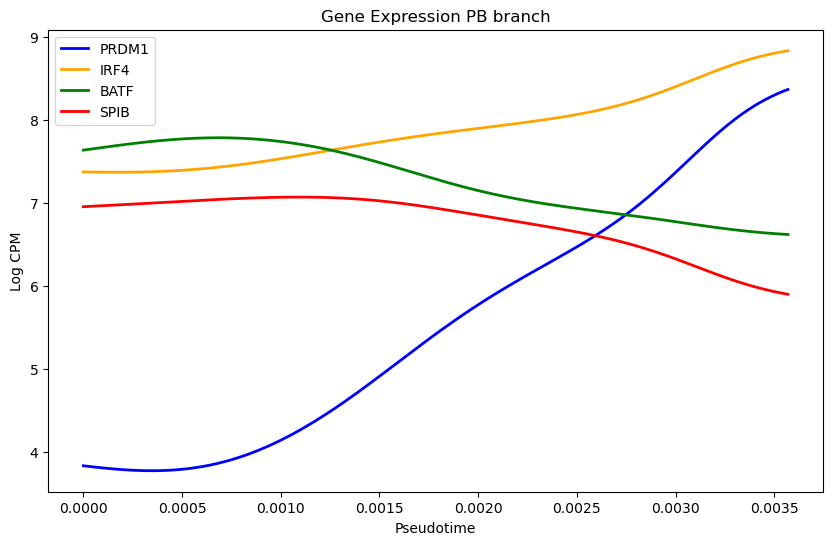

In [59]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy.index:
        plt.plot(dx, dy.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression PB branch')
plt.legend()
plt.show()

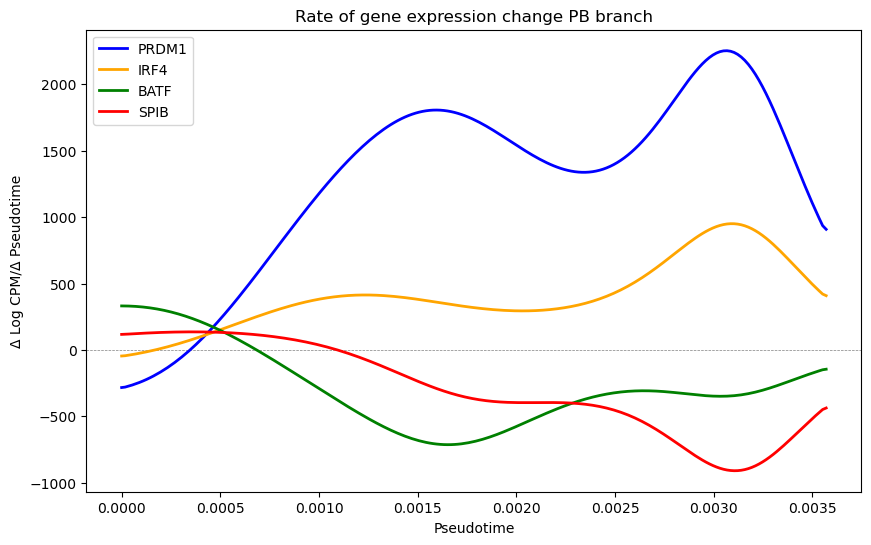

In [25]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df.index:
        plt.plot(dx, gradients_df.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log CPM/Δ Pseudotime')
plt.title('Rate of gene expression change PB branch')
plt.legend()
plt.show()

In [42]:
# Call compute_chars for regulation mode
dy_tf, dx_tf = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=2,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance (equispaced sampling with this distance)
    mode='regulation' # Use log(target count) for TFs
)

# Print basic info about the returns
print("DataFrame dy (target counts):")
print(f"Shape: {dy_tf.shape}")
print(f"First few genes: {list(dy_tf.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nTarget counts (first 5 genes x 5 timepoints):")
print(dy_tf.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx_tf)}")
print(f"First few timepoints: {list(dx_tf[:5])}")

DataFrame dy (target counts):
Shape: (245, 200)
First few genes: ['AHR', 'ARNT', 'ASCL2', 'ATF1', 'ATF2']


Target counts (first 5 genes x 5 timepoints):
              0         1         2         3         4
AHR    9.377211  9.353147  9.344296  9.335390  9.350939
ARNT   6.700440  6.700440  6.686501  6.714246  6.714246
ASCL2  3.321928  3.459432  3.459432  3.459432  3.459432
ATF1   5.392317  5.357552  5.426265  5.459432  5.459432
ATF2   6.247928  6.247928  6.209453  6.209453  6.189825
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 1.7937276396149753e-05, 3.587455279229951e-05, 5.381182918844926e-05, 7.174910558459901e-05]


In [44]:
# Calculate gradients for all TFs
gradients_df_tf = pd.DataFrame(
    np.vstack([np.gradient(dy_tf.loc[gene].values, dx_tf.values) for gene in dy_tf.index]),
    columns=dy_tf.columns,
    index=dy_tf.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df_tf.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df_tf.iloc[:5, :5])

Gradients DataFrame shape: (245, 200)

First few genes and timepoints:
                 0            1             2             3           4
AHR   -1341.547310  -917.492203 -4.949601e+02  1.851807e+02  371.789988
ARNT      0.000000  -388.553720  3.848354e+02  7.733892e+02  381.187662
ASCL2  7665.797232  3832.898616 -1.455192e-11 -1.455192e-11    0.000000
ATF1  -1938.165940   946.278888  2.839885e+03  9.245234e+02 -924.523412
ATF2      0.000000 -1072.463482 -1.072463e+03 -5.471513e+02 -547.151260


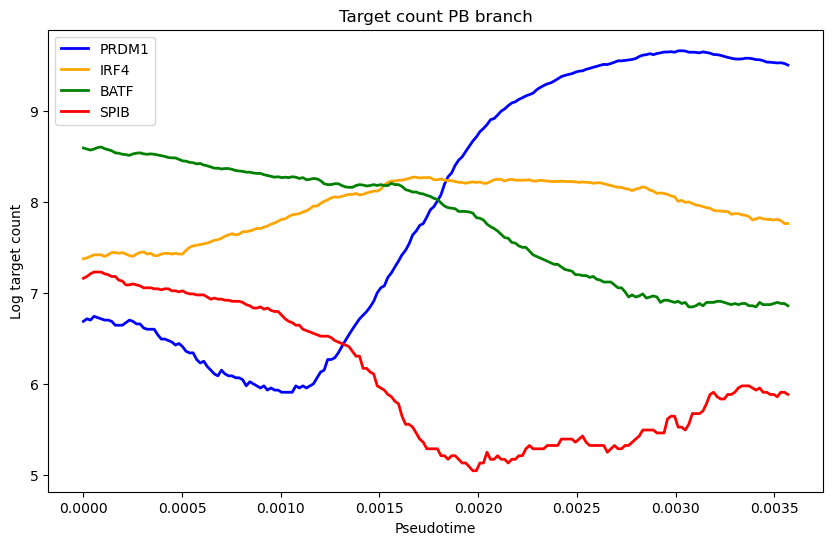

In [43]:
# Plot target count trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_tf.index:
        plt.plot(dx_tf, dy_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log target count')
plt.title('Target count PB branch')
plt.legend()
plt.show()

#### GC

In [26]:
# Call compute_chars for expression mode
dy, dx = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=3,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)

# Print basic info about the returns
print("DataFrame dy (gene expression):")
print(f"Shape: {dy.shape}")
print(f"First few genes: {list(dy.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nExpression values (first 5 genes x 5 timepoints):")
print(dy.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx)}")
print(f"First few timepoints: {list(dx[:5])}")

DataFrame dy (gene expression):
Shape: (13169, 200)
First few genes: ['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1-AS1', 'A4GALT']


Expression values (first 5 genes x 5 timepoints):
                  0         1         2         3         4
A1BG       4.092648  4.097451  4.102391  4.107468  4.112685
A1BG-AS1   3.608616  3.609388  3.610190  3.611025  3.611893
A2M        0.676537  0.667417  0.658301  0.649204  0.640146
A2ML1-AS1  1.457493  1.457455  1.457432  1.457426  1.457439
A4GALT     2.127545  2.120335  2.113166  2.106056  2.099022
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 2.087924804899648e-05, 4.175849609799296e-05, 6.263774414698945e-05, 8.351699219598593e-05]


In [27]:
# Calculate gradients for all genes
gradients_df = pd.DataFrame(
    np.vstack([np.gradient(dy.loc[gene].values, dx.values) for gene in dy.index]),
    columns=dy.columns,
    index=dy.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df.iloc[:5, :5])

Gradients DataFrame shape: (13169, 200)

First few genes and timepoints:
                    0           1           2           3           4
A1BG       230.026734  233.310764  239.898104  246.518601  253.161231
A1BG-AS1    36.962714   37.701713   39.209553   40.777386   42.405728
A2M       -436.800024 -436.710366 -436.135902 -434.756486 -432.544286
A2ML1-AS1   -1.829122   -1.457970   -0.681064    0.166370    1.086900
A4GALT    -345.299444 -344.330729 -341.958059 -338.699629 -334.526570


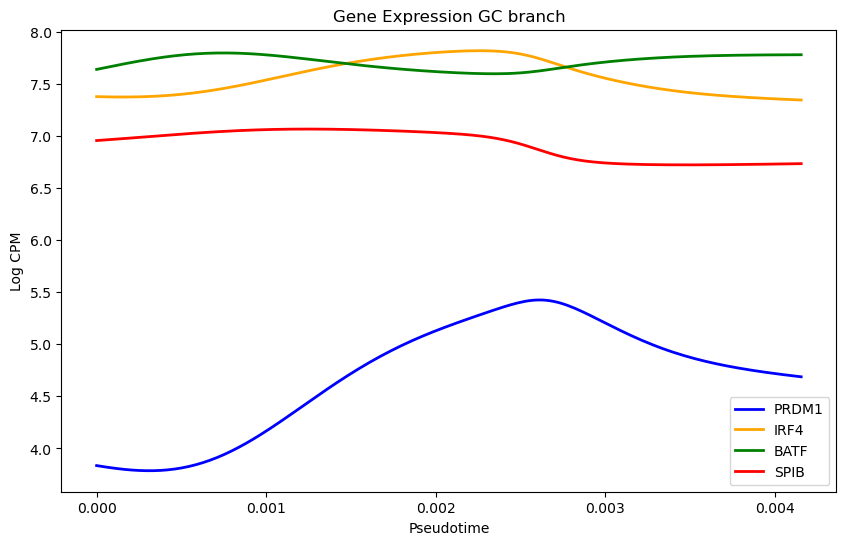

In [28]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy.index:
        plt.plot(dx, dy.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression GC branch')
plt.legend()
plt.show()

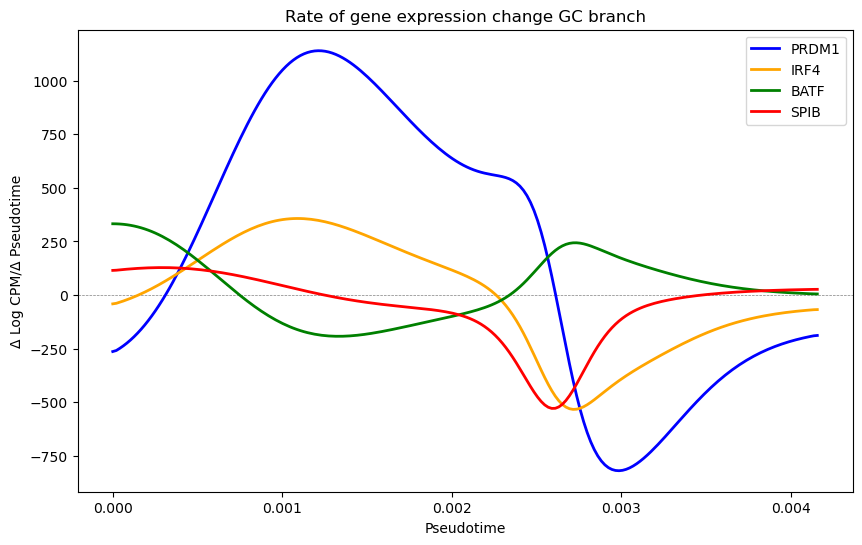

In [29]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df.index:
        plt.plot(dx, gradients_df.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log CPM/Δ Pseudotime')
plt.title('Rate of gene expression change GC branch')
plt.legend()
plt.show()

In [38]:
# Call compute_chars for regulation mode
dy_tf, dx_tf = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=3,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance (equispaced sampling with this distance)
    mode='regulation' # Use log(target count) for TFs
)

# Print basic info about the returns
print("DataFrame dy (target counts):")
print(f"Shape: {dy_tf.shape}")
print(f"First few genes: {list(dy_tf.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nTarget counts (first 5 genes x 5 timepoints):")
print(dy_tf.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx_tf)}")
print(f"First few timepoints: {list(dx_tf[:5])}")

DataFrame dy (target counts):
Shape: (245, 200)
First few genes: ['AHR', 'ARNT', 'ASCL2', 'ATF1', 'ATF2']


Target counts (first 5 genes x 5 timepoints):
              0         1         2         3         4
AHR    9.379378  9.355351  9.339850  9.335390  9.339850
ARNT   6.727920  6.714246  6.700440  6.754888  6.754888
ASCL2  3.321928  3.459432  3.459432  3.459432  3.459432
ATF1   5.392317  5.392317  5.426265  5.459432  5.426265
ATF2   6.266787  6.228819  6.209453  6.209453  6.149747
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 2.087924804899648e-05, 4.175849609799296e-05, 6.263774414698945e-05, 8.351699219598593e-05]


In [39]:
# Calculate gradients for all TFs
gradients_df_tf = pd.DataFrame(
    np.vstack([np.gradient(dy_tf.loc[gene].values, dx_tf.values) for gene in dy_tf.index]),
    columns=dy_tf.columns,
    index=dy_tf.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df_tf.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df_tf.iloc[:5, :5])

Gradients DataFrame shape: (245, 200)

First few genes and timepoints:
                 0            1            2             3           4
AHR   -1150.772796  -946.594535  -478.004325 -2.910383e-11 -107.127339
ARNT   -654.953515  -658.087311   973.262648  1.303873e+03  318.421971
ASCL2  6585.654973  3292.827487     0.000000 -1.455192e-11    0.000000
ATF1      0.000000   812.944313  1607.198585  0.000000e+00 -794.254272
ATF2  -1818.449118 -1372.970304  -463.745745 -1.429799e+03 -470.055404


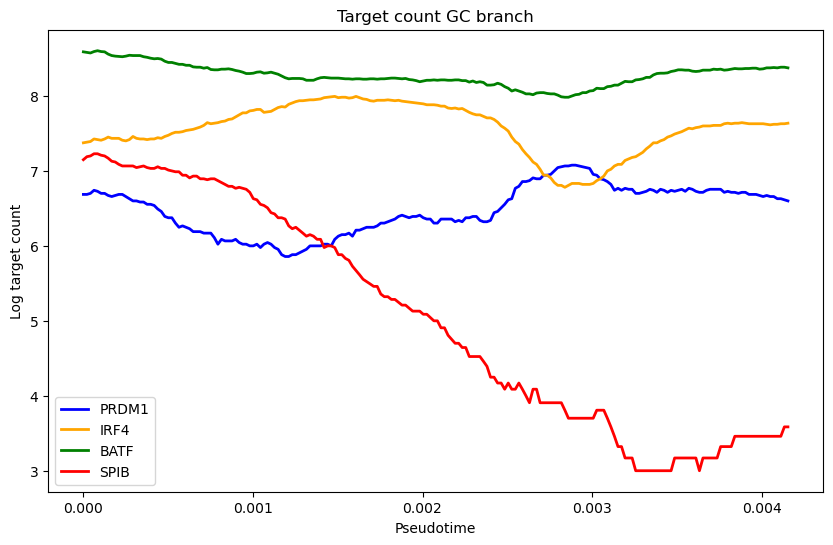

In [41]:
# Plot target count trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_tf.index:
        plt.plot(dx_tf, dy_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log target count')
plt.title('Target count GC branch')
plt.legend()
plt.show()

# Combinatorial Control of TFs

In [5]:
# get TF pairs from combinatorial control
tf_pairs_df = pd.read_csv(tf_pairs_file)
tf_pairs_and_targets = tf_pairs_df[['TF', 'common']]
display(tf_pairs_and_targets)

,TF,common
0,"('AFF1', 'IRF4')","{'PRDM1', 'AFF3', 'ANKRD28', 'ELL2', 'HSP90B1'}"
1,"('ATF5', 'CREB3L2')","{'FNDC3B', 'SEL1L3', 'BTG2', 'SLAMF7', 'ARFGAP..."
2,"('BACH2', 'EBF1')","{'JCHAIN', 'XBP1', 'MZB1'}"
3,"('BACH2', 'FLI1')","{'JCHAIN', 'XBP1', 'MZB1'}"
4,"('BACH2', 'FOSB')","{'JCHAIN', 'XBP1', 'MZB1'}"
...,...,...
145,"('XBP1', 'IRF4')","{'TXNDC11', 'FNDC3B', 'PRDM1', 'AFF3', 'JCHAIN..."
146,"('XBP1', 'TAF3')","{'HSP90B1', 'FNDC3B', 'TXNDC5'}"
147,"('ZBTB16', 'IRF4')","{'AFF3', 'HSP90B1'}"
148,"('ZBTB16', 'XBP1')","{'JCHAIN', 'HSP90B1'}"


In [6]:
all_tfs = []
for pair_str in tf_pairs_and_targets['TF']:
    tf1, tf2 = eval(pair_str)  # Convert string representation to actual tuple
    all_tfs.extend([tf1, tf2])  # Add both TFs to the list

# Get unique TFs using set
unique_tfs = sorted(set(all_tfs))

print(f"Number of unique TFs: {len(unique_tfs)}")
print("Unique TFs:", unique_tfs)

Number of unique TFs: 75
Unique TFs: ['AFF1', 'ARID5B', 'ATF5', 'BACH2', 'BATF3', 'BCL11A', 'BCL6', 'BHLHE22', 'BHLHE41', 'CHD1', 'CREB3L2', 'EBF1', 'EGR1', 'ESR1', 'FLI1', 'FOSB', 'FOSL1', 'FOXO1', 'HBP1', 'HERPUD1', 'HIVEP1', 'HIVEP2', 'HIVEP3', 'ID2', 'IKZF1', 'IRF4', 'IRF8', 'JUN', 'JUNB', 'KLF2', 'KLF4', 'L3MBTL4', 'MEF2A', 'MEF2C', 'NFATC2', 'NFKB1', 'NR6A1', 'NRF1', 'PAX5', 'PBX3', 'PBX4', 'PHF21A', 'PLAG1', 'PLAGL1', 'POLR2A', 'POU3F1', 'PRDM1', 'PTEN', 'REL', 'RFX3', 'RREB1', 'RUNX1', 'RUNX2', 'SMAD3', 'SOX4', 'SP3', 'STAT1', 'STAT4', 'TAF1', 'TAF3', 'TCF12', 'TCF4', 'TCFL5', 'TET3', 'TFDP2', 'TFEB', 'TFEC', 'TGIF1', 'XBP1', 'ZBTB16', 'ZBTB7A', 'ZFHX3', 'ZNF318', 'ZNF506', 'ZNF652']


In [7]:
# get unique targets by opening up the {} where all targets are stored and appending to a set
unique_targets = set()
for target_set in tf_pairs_and_targets['common']:
    unique_targets.update(eval(target_set))
unique_targets = sorted(unique_targets)
print(f"Number of unique targets: {len(unique_targets)}")
print("Unique targets:", unique_targets)


Number of unique targets: 23
Unique targets: ['AFF3', 'ANKRD28', 'ARFGAP3', 'BTG2', 'CD74', 'ELL2', 'FNDC3B', 'GLCCI1', 'HSP90B1', 'IRF4', 'JCHAIN', 'MED23', 'MZB1', 'PAX5', 'PDE4D', 'PRDM1', 'RUNX2', 'SEL1L3', 'SLAMF7', 'TRAM1', 'TXNDC11', 'TXNDC5', 'XBP1']


### Filtering TF-Target pairs based on edge significance

In [8]:
cc_tf_target_pairs = create_tf_target_pairs(dictys_dynamic_object, tf_pairs_and_targets)
display(cc_tf_target_pairs)

Created 196 unique TF-target pairs


[('STAT4', 'BTG2'),
 ('SMAD3', 'RUNX2'),
 ('NR6A1', 'BTG2'),
 ('ZFHX3', 'BTG2'),
 ('MEF2C', 'SEL1L3'),
 ('XBP1', 'PAX5'),
 ('PBX3', 'PRDM1'),
 ('PLAG1', 'TRAM1'),
 ('PRDM1', 'PAX5'),
 ('REL', 'HSP90B1'),
 ('IRF4', 'ANKRD28'),
 ('NR6A1', 'TRAM1'),
 ('STAT1', 'MZB1'),
 ('IRF4', 'XBP1'),
 ('STAT1', 'RUNX2'),
 ('IRF4', 'SLAMF7'),
 ('FOSB', 'XBP1'),
 ('IRF4', 'GLCCI1'),
 ('NRF1', 'JCHAIN'),
 ('MEF2A', 'JCHAIN'),
 ('FLI1', 'ELL2'),
 ('FLI1', 'IRF4'),
 ('NFKB1', 'XBP1'),
 ('PAX5', 'FNDC3B'),
 ('TGIF1', 'TXNDC5'),
 ('MEF2C', 'MZB1'),
 ('NFKB1', 'GLCCI1'),
 ('SP3', 'AFF3'),
 ('PRDM1', 'XBP1'),
 ('PLAG1', 'SEL1L3'),
 ('RREB1', 'JCHAIN'),
 ('RFX3', 'SEL1L3'),
 ('JUN', 'IRF4'),
 ('BACH2', 'AFF3'),
 ('RFX3', 'PAX5'),
 ('KLF4', 'HSP90B1'),
 ('IRF4', 'JCHAIN'),
 ('FOSB', 'JCHAIN'),
 ('BACH2', 'XBP1'),
 ('BACH2', 'GLCCI1'),
 ('NFKB1', 'JCHAIN'),
 ('PAX5', 'AFF3'),
 ('TGIF1', 'TXNDC11'),
 ('RREB1', 'TXNDC5'),
 ('BCL6', 'AFF3'),
 ('MEF2A', 'MZB1'),
 ('SOX4', 'AFF3'),
 ('IRF8', 'IRF4'),
 ('REL', 'PRDM1')

In [9]:
# Get unique TFs and targets from the pairs
tfs = sorted(set(pair[0] for pair in cc_tf_target_pairs))
targets = sorted(set(pair[1] for pair in cc_tf_target_pairs))

# Create DataFrame with TFs as rows and targets as columns
cc_tf_target_pairs_df = pd.DataFrame(0, index=tfs, columns=targets)

# Fill in the DataFrame with 1s for existing TF-target pairs
for tf, target in cc_tf_target_pairs:
    cc_tf_target_pairs_df.loc[tf, target] = 1

display(cc_tf_target_pairs_df)

,AFF3,ANKRD28,BTG2,CD74,ELL2,FNDC3B,GLCCI1,HSP90B1,IRF4,JCHAIN,...,PAX5,PDE4D,PRDM1,RUNX2,SEL1L3,SLAMF7,TRAM1,TXNDC11,TXNDC5,XBP1
BACH2,1,0,0,0,0,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,1
BATF3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BCL6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
EGR1,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ESR1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
FLI1,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
FOSB,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
FOSL1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
FOXO1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HBP1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Get the edge weights of TF-target pairs per branch

In [10]:
# now get the tf indices for the tfs in cc_tf_target_pairs
tf_indices_cc, _ = get_tf_indices(dictys_dynamic_object, tfs)
display(len(tf_indices_cc))

40

In [11]:
# get the gene indices for the targets in cc_tf_target_pairs
gene_indices_cc = get_target_gene_indices(dictys_dynamic_object, targets)
display(len(gene_indices_cc))
#display(gene_indices_cc)

22

#### Filter pairs based on branch sparsity and absolute edge weight

In [28]:
# get weights across windows
weights_tf_target_pb = get_weights_for_tf_target_pairs(dictys_dynamic_object, tf_indices_cc, gene_indices_cc, pb_window_indices)
weights_tf_target_gc = get_weights_for_tf_target_pairs(dictys_dynamic_object, tf_indices_cc, gene_indices_cc, gc_window_indices)

In [29]:
display(weights_tf_target_pb.shape)

(40, 22, 17)

In [30]:
display(np.max(weights_tf_target_pb))
display(np.min(weights_tf_target_pb))
display(np.max(weights_tf_target_gc))
display(np.min(weights_tf_target_gc))


np.float64(1.9487169016022052)

np.float64(-1.2820989402133387)

np.float64(2.042809333337349)

np.float64(-1.480683317811162)

In [6]:
def filter_tf_target_pairs(weights, sparsity_threshold=0.3, weight_percentile=90):
    """
    Filter TF-target pairs based on sparsity and absolute weight thresholds
    
    Args:
        weights: numpy array of shape (n_tfs, n_targets, n_windows)
        sparsity_threshold: minimum fraction of windows where edge weight should be non-zero
        weight_percentile: percentile threshold for absolute edge weights
        
    Returns:
        mask: boolean array of shape (n_tfs, n_targets) where True indicates pairs that pass both filters
    """
    # 1. Sparsity filter - check fraction of non-zero windows
    nonzero_frac = (weights != 0).mean(axis=2)  # Shape: (40, 22)
    sparsity_mask = nonzero_frac >= sparsity_threshold
    
    # 2. Weight threshold filter
    abs_weights = np.abs(weights)
    weight_threshold = np.percentile(abs_weights, weight_percentile)
    max_abs_weights = abs_weights.max(axis=2)  # Shape: (40, 22)
    weight_mask = max_abs_weights >= weight_threshold
    
    # Combine both filters (AND operation)
    final_mask = sparsity_mask & weight_mask
    
    return final_mask

def get_filtered_pairs(mask, tf_names, target_names, total_pairs=None):
    """
    Convert boolean mask to list of passing TF-target pairs
    
    Args:
        mask: boolean array of shape (n_tfs, n_targets)
        tf_names: list of TF names
        target_names: list of target gene names
        total_pairs: optional list of allowed TF-target pairs to filter by
    
    Returns:
        list of tuples [(tf_name, target_name), ...]
    """
    # Get indices where mask is True
    tf_indices, target_indices = np.where(mask)
    # Convert indices to names and optionally filter by total pairs
    filtered_pairs = []
    for tf_idx, target_idx in zip(tf_indices, target_indices):
        pair = (tf_names[tf_idx], target_names[target_idx])
        if total_pairs is None or pair in total_pairs:
            filtered_pairs.append(pair)
    return filtered_pairs

#### GC branch

In [107]:
# Example usage
mask_gc = filter_tf_target_pairs(weights_tf_target_gc, 
                                      sparsity_threshold=0.99,  
                                      weight_percentile=99.00)
filtered_pairs_gc = get_filtered_pairs(mask_gc, tfs, targets)

# Get number of pairs that pass the filter
print(f"Number of filtered pairs: {len(filtered_pairs_gc)}")
display(filtered_pairs_gc)

Number of filtered pairs: 21


[('FLI1', 'IRF4'),
 ('FOXO1', 'AFF3'),
 ('IKZF1', 'IRF4'),
 ('MEF2A', 'ANKRD28'),
 ('MEF2A', 'SEL1L3'),
 ('MEF2C', 'ANKRD28'),
 ('NFKB1', 'IRF4'),
 ('NRF1', 'AFF3'),
 ('NRF1', 'ANKRD28'),
 ('NRF1', 'PAX5'),
 ('PAX5', 'MZB1'),
 ('PAX5', 'RUNX2'),
 ('PBX3', 'BTG2'),
 ('REL', 'IRF4'),
 ('RUNX1', 'AFF3'),
 ('RUNX2', 'AFF3'),
 ('SOX4', 'AFF3'),
 ('STAT1', 'MZB1'),
 ('STAT1', 'SLAMF7'),
 ('TFEB', 'TXNDC5'),
 ('XBP1', 'HSP90B1')]

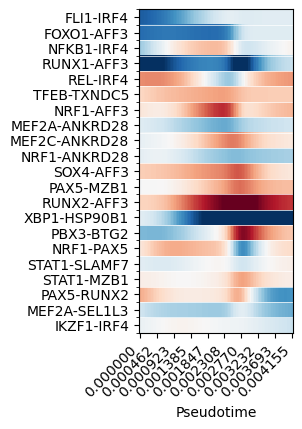

In [108]:
fig, ax, cmap = fig_regulation_heatmap_clustered(
    network=dictys_dynamic_object,
    start=1,
    stop=3,
    regulations=filtered_pairs_gc,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    cmap='RdBu',  # Red indicates higher values, Blue indicates lower values
    figsize=(2, 0.2),  # Reduced row height to 0.15
    use_max=True  # extremum based sorting of rows
)

### PB branch

In [109]:
# Example usage
mask_pb = filter_tf_target_pairs(weights_tf_target_pb, 
                                      sparsity_threshold=0.99,  
                                      weight_percentile=99.00)   
filtered_pairs_pb = get_filtered_pairs(mask_pb, tfs, targets)

# Get number of pairs that pass the filter
print(f"Number of filtered pairs: {len(filtered_pairs_pb)}")
display(filtered_pairs_pb)

Number of filtered pairs: 28


[('ESR1', 'PRDM1'),
 ('FOXO1', 'AFF3'),
 ('IKZF1', 'MED23'),
 ('KLF4', 'JCHAIN'),
 ('KLF4', 'RUNX2'),
 ('MEF2A', 'ANKRD28'),
 ('MEF2A', 'SEL1L3'),
 ('MEF2C', 'SEL1L3'),
 ('NFKB1', 'IRF4'),
 ('NRF1', 'ANKRD28'),
 ('NRF1', 'PAX5'),
 ('NRF1', 'RUNX2'),
 ('NRF1', 'TXNDC11'),
 ('PAX5', 'MZB1'),
 ('PAX5', 'RUNX2'),
 ('PBX3', 'ANKRD28'),
 ('PBX3', 'BTG2'),
 ('PRDM1', 'GLCCI1'),
 ('REL', 'MED23'),
 ('RUNX1', 'AFF3'),
 ('RUNX2', 'AFF3'),
 ('STAT1', 'MZB1'),
 ('STAT1', 'SLAMF7'),
 ('TFEB', 'HSP90B1'),
 ('TFEB', 'PRDM1'),
 ('TFEB', 'TRAM1'),
 ('XBP1', 'PRDM1'),
 ('XBP1', 'TRAM1')]

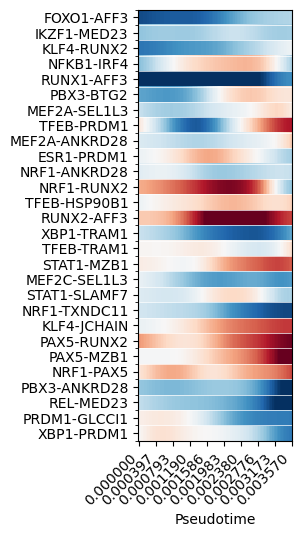

In [110]:
fig, ax, cmap = fig_regulation_heatmap_clustered(
    network=dictys_dynamic_object,
    start=1,
    stop=2,
    regulations=filtered_pairs_pb,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    cmap='RdBu',  # Red indicates higher values, Blue indicates lower values
    figsize=(2, 0.2),  # Reduced row height to 0.15
    use_max=True  # extremum based sorting of rows
)

### Sub-GRN PAX5

In [7]:
# get PAX5 TF indice
pax5_tf_idx, _ = get_tf_indices(dictys_dynamic_object, ['PAX5'])
display(pax5_tf_idx)

[163]

In [8]:
# get weights of PAX5 over all windows
pax5_weights_pb = get_grn_weights_across_windows(dictys_dynamic_object, pax5_tf_idx, pb_with_actb_indices)
display(pax5_weights_pb.shape)


(1, 13169, 45)

In [9]:
# get weights of PAX5 over all windows
pax5_weights_gc = get_grn_weights_across_windows(dictys_dynamic_object, pax5_tf_idx, gc_with_actb_indices)
display(pax5_weights_gc.shape)


(1, 13169, 44)

In [10]:
def get_passing_targets(weights, tf_names, target_names, sparsity_threshold=0.99, weight_percentile=99.00):
    """
    Get targets that pass sparsity and weight thresholds for given TFs
    """
    # Get mask using existing filter function
    mask = filter_tf_target_pairs(weights, 
                                sparsity_threshold=sparsity_threshold,
                                weight_percentile=weight_percentile)
    passing_targets = {}
    # For each TF, get its passing targets
    for tf_idx, tf_name in enumerate(tf_names):
        # Get indices of targets that pass for this TF
        target_indices = np.where(mask[tf_idx, :])[0]
        # Convert indices to target names
        passing_target_names = [target_names[idx] for idx in target_indices]
        # Store in dictionary if there are any passing targets
        if passing_target_names:
            passing_targets[tf_name] = passing_target_names
    return passing_targets

In [11]:
# Example usage for PAX5:
target_names = get_all_target_names(dictys_dynamic_object)
pax5_passing_targets_in_pb_branch = get_passing_targets(
    pax5_weights_pb,
    tf_names=['PAX5'],  # Single TF
    target_names=target_names,  # All possible target genes
    sparsity_threshold=0.99,
    weight_percentile=99.93
)

# Print results
for tf, targets in pax5_passing_targets_in_pb_branch.items():
    print(f"\n{tf} has {len(targets)} passing targets in PB branch:")
    print(f"Targets: {', '.join(targets)}")


PAX5 has 25 passing targets in PB branch:
Targets: ABCC1, C5orf24, CBWD2, CD81, CYB5A, DMXL1, FAM133B, GATAD1, HSF2, KCNQ1OT1, MYH11, MZB1, N4BP2L2, PAIP2, PCBD2, PDS5B, PEX1, PPFIBP2, RBM48, RUNX2, SNHG4, SUPT3H, TSSC4, TXNDC15, ZNF407


In [12]:
# create a list of tupke with pax5 tf and all the targets that pass the filter
pax5_pb_filtered_pairs = [(tf, str(target)) for target in pax5_passing_targets_in_pb_branch['PAX5']]
display(pax5_pb_filtered_pairs)

[('PAX5', 'ABCC1'),
 ('PAX5', 'C5orf24'),
 ('PAX5', 'CBWD2'),
 ('PAX5', 'CD81'),
 ('PAX5', 'CYB5A'),
 ('PAX5', 'DMXL1'),
 ('PAX5', 'FAM133B'),
 ('PAX5', 'GATAD1'),
 ('PAX5', 'HSF2'),
 ('PAX5', 'KCNQ1OT1'),
 ('PAX5', 'MYH11'),
 ('PAX5', 'MZB1'),
 ('PAX5', 'N4BP2L2'),
 ('PAX5', 'PAIP2'),
 ('PAX5', 'PCBD2'),
 ('PAX5', 'PDS5B'),
 ('PAX5', 'PEX1'),
 ('PAX5', 'PPFIBP2'),
 ('PAX5', 'RBM48'),
 ('PAX5', 'RUNX2'),
 ('PAX5', 'SNHG4'),
 ('PAX5', 'SUPT3H'),
 ('PAX5', 'TSSC4'),
 ('PAX5', 'TXNDC15'),
 ('PAX5', 'ZNF407')]

In [13]:
pax5_passing_targets_in_gc_branch = get_passing_targets(
    pax5_weights_gc,
    tf_names=['PAX5'],  # Single TF
    target_names=target_names,  # All possible target genes
    sparsity_threshold=0.99,
    weight_percentile=99.95
)

# Print results
for tf, targets in pax5_passing_targets_in_gc_branch.items():
    print(f"\n{tf} has {len(targets)} passing targets in GC branch:")
    print(f"Targets: {', '.join(targets)}")


PAX5 has 25 passing targets in GC branch:
Targets: ABCC1, ATP6V0C, CD81, CENPU, CHD3, CNDP2, E4F1, JPT2, MLST8, MSRB1, MZB1, NAA38, NCAPD3, NME3, PDPK1, RNPS1, RPS2, RUNX2, SNHG4, SNHG9, SUPT3H, TBC1D24, TRAF7, TSSC4, WIPI2


In [14]:
# create a list of tupke with pax5 tf and all the targets that pass the filter
pax5_gc_filtered_pairs = [(tf, str(target)) for target in pax5_passing_targets_in_gc_branch['PAX5']]
display(pax5_gc_filtered_pairs)

[('PAX5', 'ABCC1'),
 ('PAX5', 'ATP6V0C'),
 ('PAX5', 'CD81'),
 ('PAX5', 'CENPU'),
 ('PAX5', 'CHD3'),
 ('PAX5', 'CNDP2'),
 ('PAX5', 'E4F1'),
 ('PAX5', 'JPT2'),
 ('PAX5', 'MLST8'),
 ('PAX5', 'MSRB1'),
 ('PAX5', 'MZB1'),
 ('PAX5', 'NAA38'),
 ('PAX5', 'NCAPD3'),
 ('PAX5', 'NME3'),
 ('PAX5', 'PDPK1'),
 ('PAX5', 'RNPS1'),
 ('PAX5', 'RPS2'),
 ('PAX5', 'RUNX2'),
 ('PAX5', 'SNHG4'),
 ('PAX5', 'SNHG9'),
 ('PAX5', 'SUPT3H'),
 ('PAX5', 'TBC1D24'),
 ('PAX5', 'TRAF7'),
 ('PAX5', 'TSSC4'),
 ('PAX5', 'WIPI2')]

In [21]:
# create a list of tuples with pairs of pax5 coming from both branches, accounting for duplicates
pax5_filtered_pairs_all = list(set(pax5_pb_filtered_pairs + pax5_gc_filtered_pairs))
display(len(pax5_filtered_pairs_all))

43

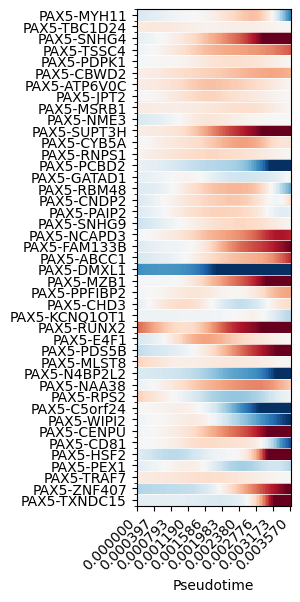

In [22]:
# draw the heatmap of the filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,
    stop=2,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

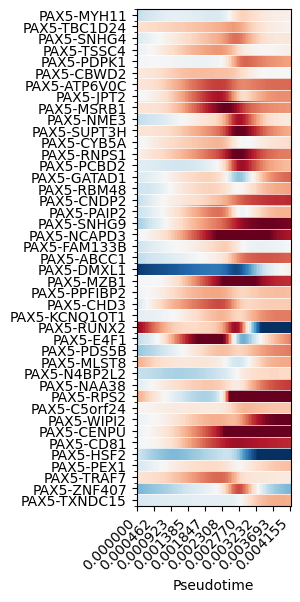

In [23]:
# draw the heatmap of the filtered pairs
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,
    stop=3,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

In [38]:
def fig_expression_gradient_heatmap(
    network: dictys.net.dynamic_network,
    start: int,
    stop: int,
    regulations: list[Tuple[str, str]],
    num: int = 100,
    dist: float = 1.5,
    ax: Optional[matplotlib.axes.Axes] = None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    figsize: Tuple[float, float] = (2, 0.15)
) -> Tuple[matplotlib.pyplot.Figure, matplotlib.axes.Axes, matplotlib.cm.ScalarMappable]:
    """
    Draws pseudo-time dependent heatmap of expression gradients for target genes.
    """
    # Get expression data
    dy, dx = compute_chars(network, start, stop, num, dist, mode='expression')
    
     # Get target genes in the order they appear in regulations
    target_genes = [target for _, target in regulations]
    # Remove duplicates while preserving order
    target_genes = list(dict.fromkeys(target_genes))
    # Calculate gradients for target genes
    gradients = np.vstack([
        np.gradient(dy.loc[gene].values, dx.values) 
        for gene in target_genes
    ])
    
    # Create figure and axes
    if ax is None:
        figsize = (figsize[0], figsize[1] * len(target_genes))
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        if figsize is not None:
            raise ValueError("figsize should not be set if ax is set.")
        fig = ax.get_figure()
        figsize = fig.get_size_inches()
    
    aspect = (figsize[1] / len(target_genes)) / (figsize[0] / gradients.shape[1])
    
    # Determine and apply colormap
    if isinstance(cmap, str):
        vmax = np.quantile(np.abs(gradients).ravel(), 0.95)
        cmap = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax), 
            cmap=cmap
        )
    
    if hasattr(cmap, "to_rgba"):
        im = ax.imshow(cmap.to_rgba(gradients), aspect=aspect, interpolation='none')
    else:
        im = ax.imshow(gradients, aspect=aspect, interpolation='none', cmap=cmap)
        plt.colorbar(im, label="Expression gradient (Δ Log CPM/Δ Pseudotime)")
    
    # Set pseudotime labels as x axis labels
    ax.set_xlabel("Pseudotime")
    num_ticks = 10
    tick_positions = np.linspace(0, gradients.shape[1] - 1, num_ticks, dtype=int)
    tick_labels = dx.iloc[tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f"{x:.6f}" for x in tick_labels], rotation=45, ha="right")
    
    # Set target gene labels
    ax.set_yticks(list(range(len(target_genes))))
    ax.set_yticklabels(target_genes)
    
    # Add grid lines to separate rows
    ax.set_yticks(np.arange(len(target_genes) + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
    
    return fig, ax, cmap

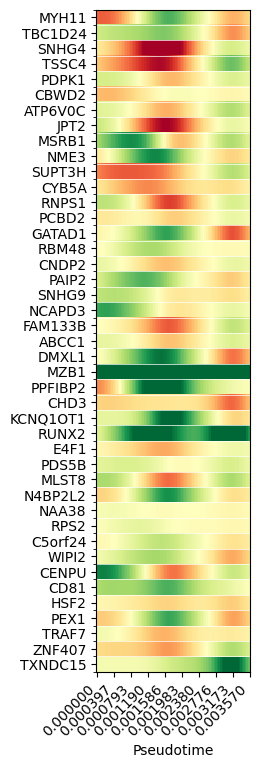

In [39]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=1,
    stop=2,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)

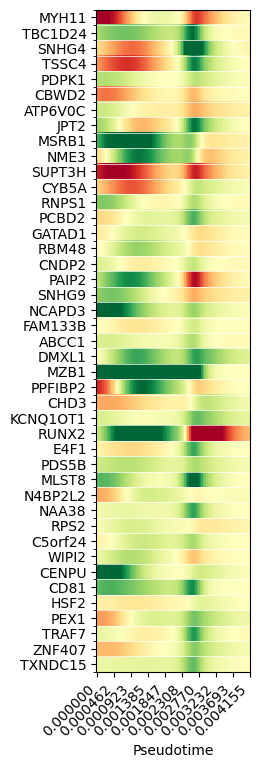

In [40]:
# Example usage:
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=1,
    stop=3,
    regulations=pax5_filtered_pairs_all,
    num=100,
    dist=0.0005,
    cmap='RdYlGn', # Red = negative gradient, Yellow = neutral, Green = positive gradient
    figsize=(2, 0.2)
)